<a href="https://colab.research.google.com/github/vanle2000/Chronic-disease_data-mining/blob/main/CSE469FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import seaborn as sns
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.naive_bayes import GaussianNB


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# EDA

In [ ]:
dtype = {
    'YearStart': int,
    'YearEnd': int,
    'LocationAbbr': object,
    'LocationDesc': object,
    'DataSource': object,
    'Topic': object,
    'Question': object,
    'Response': float,
    'DataValueUnit': object,
    'DataValueType': float,
    'DataValue': object,
    'DataValueAlt': float,
    'DataValueFootnoteSymbol': object,
    'DatavalueFootnote': object,
    'LowConfidenceLimit': float,
    'HighConfidenceLimit': float,
    'StratificationCategory1': object,
    'Stratification1': object,
    'StratificationCategory2': float,
    'Stratification2': float,
    'StratificationCategory3': float,
    'Stratification3': float,
    'GeoLocation': object,
    'ResponseID': float,
    'LocationID': int,
    'TopicID': object,
    'QuestionID': object,
    'DataValueTypeID': object,
    'StratificationCategoryID1': object,
    'StratificationID1': object,
    'StratificationCategoryID2': float,
    'StratificationID2': float,
    'StratificationCategoryID3': float,
    'StratificationID3': float
}

df = pd.read_csv('/content/drive/My Drive/DM Project/U.S._Chronic_Disease_Indicators__CDI_.csv', low_memory=False)
# df = pd.read_csv('/content/drive/My Drive/U.S._Chronic_Disease_Indicators__CDI_.csv', dtype=dtype, low_memory=False)

FileNotFoundError: ignored

#### Handling data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Topic   17 non-null     object
dtypes: object(1)
memory usage: 264.0+ bytes


In [ ]:
# handle mix columns value
df['DataValue'] = pd.to_numeric(df['DataValue'], errors='coerce')

KeyError: ignored

In [ ]:
# sort the data based on year
df = df.sort_values(by=['YearStart'], axis=0, ascending=True, inplace=False, na_position='last').reset_index()
df.head()

#### Handling missing values

In [ ]:
df.isnull().sum()

In [ ]:
# drop columns with all null
df = df.dropna(axis=1, how='all')

In [ ]:
# remove rows where DataValueAlt is null
df = df.dropna(subset=['DataValueAlt'])
df.isnull().sum()

In [ ]:
#  Remove unwanted columns
df = df.drop(columns=['index', 'LocationDesc',
                      'DataValueFootnoteSymbol', 'DatavalueFootnote',
                      'LowConfidenceLimit', 'HighConfidenceLimit'],
             axis=1)

In [ ]:
# remove all rows that have null value in `GeoLocation`
# our df then contains only data where `GeoLocation` column has non-null values.
mask_df=df['GeoLocation'].isnull()
df = df[~mask_df]

In [ ]:
df.isnull().sum()

#### Extract latitude and longitude from the `GeoLocation`

In [ ]:
df['GeoLocation']

In [ ]:
df[['Longitude', 'Latitude']] = df['GeoLocation'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df = df.drop(['GeoLocation'], axis=1)

In [ ]:
# using mode of related columns such `Topic` and `Question` to fill missing values in `DataValueUnit`
# we group data by `Topic` and `Question`, then fill the missing with mode value within the group

for name, group in df.groupby(['Topic', 'Question']):
  mode_values= group['DataValueUnit'].mode()
  if not mode_values.empty:
    mode_value = mode_values.iloc[0]
    df.loc[(df['Topic'] == name[0]) & (df['Question'] == name[1]) & (df['DataValueUnit'].isna()), 'DataValueUnit'] = mode_value

print(f"Number of empty value in `DataValueUnit` is:", df['DataValueUnit'].isnull().sum())


In [ ]:
df.to_csv("Cleaned_Chronic_Disease_Indicators.csv")

# Geographic Patterns and Trend Analysis

In [ ]:
clean_df = pd.read_csv("/content/drive/My Drive/DM Project/Cleaned_Chronic_Disease_Indicators-2.csv")

In [ ]:
clean_df.drop(['Unnamed: 0'], axis=1, inplace=True)
clean_df.head()

YearStart  YearEnd LocationAbbr       DataSource                   Topic  \
0       2001     2001           NJ  NVSS, Mortality  Overarching Conditions   
1       2001     2001           OH  NVSS, Mortality  Overarching Conditions   
2       2001     2001           NJ  NVSS, Mortality  Overarching Conditions   
3       2001     2001           MA  NVSS, Mortality  Overarching Conditions   
4       2001     2001           KS  NVSS, Mortality  Overarching Conditions   

                          Question DataValueUnit DataValueType  DataValue  \
0         Life expectancy at birth         Years        Number       77.6   
1         Life expectancy at birth         Years        Number       76.5   
2  Life expectancy at age 65 years         Years        Number       18.1   
3  Life expectancy at age 65 years         Years        Number       18.7   
4         Life expectancy at birth         Years        Number       77.8   

   DataValueAlt StratificationCategory1 Stratification1  LocationID TopicID  \
0          77.6                 Overall         Overall          34     OVC   
1          76.5                 Overall         Overall          39     OVC   
2          18.1                 Overall         Overall          34     OVC   
3          18.7                 Overall         Overall          25     OVC   
4          77.8                 Overall         Overall          20     OVC   

  QuestionID DataValueTypeID StratificationCategoryID1 StratificationID1  \
0     OVC4_1            NMBR                   OVERALL               OVR   
1     OVC4_1            NMBR                   OVERALL               OVR   
2     OVC4_2            NMBR                   OVERALL               OVR   
3     OVC4_2            NMBR                   OVERALL               OVR   
4     OVC4_1            NMBR                   OVERALL               OVR   

   Longitude  Latitude  
0 -74.273691  40.13057  
1 -82.404260  40.06021  
2 -74.273691  40.13057  
3 -72.082691  42.27687  
4 -98.200781  38.34774

In [ ]:
clean_df.columns

Index(['Unnamed: 0', 'YearStart', 'YearEnd', 'LocationAbbr', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'StratificationCategory1', 'Stratification1',
       'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1', 'Longitude',
       'Latitude'],
      dtype='object')

### Death Status from `DataSource`

In [ ]:
clean_df['DataSource'].unique()

array(['NVSS, Mortality', 'STATE', 'Statewide central cancer registries',
       'Death Certificate', 'PRAMS', 'NVSS', 'ACS 1-Year Estimates',
       'CMS Part A Claims Data', 'CMS CCW', 'Current Population Survey',
       'ACS 5-Year Estimates', 'SEDD; SID', 'Birth Certificate, NVSS',
       'National Immunization Survey', 'AEDS', 'BRFSS', 'USRDS',
       'CDC Breastfeeding Report Card', 'mPINC',
       'CDC School Health Profiles',
       "USDA National Farmers' Market Directory", 'WFRS', 'HRSA, UDS',
       'APIS', 'YRBSS', 'InfoUSA; USDA', 'ANRF', 'NSCH'], dtype=object)

In [ ]:
# create `DeathStatus`
dead_sources = ['Death Certificate', 'NVSS, Mortality', 'NVSS']
# create new attribute and record them in `Status`
clean_df['DeadStatus'] = 0
# record '1' if the data source in dead_sources
clean_df.loc[clean_df['DataSource'].isin(dead_sources), 'DeadStatus'] = 1

In [ ]:
clean_df = clean_df.drop(columns='DataSource')
clean_df.head()

YearStart  YearEnd LocationAbbr                   Topic  \
0       2001     2001           NJ  Overarching Conditions   
1       2001     2001           OH  Overarching Conditions   
2       2001     2001           NJ  Overarching Conditions   
3       2001     2001           MA  Overarching Conditions   
4       2001     2001           KS  Overarching Conditions   

                          Question DataValueUnit DataValueType  DataValue  \
0         Life expectancy at birth         Years        Number       77.6   
1         Life expectancy at birth         Years        Number       76.5   
2  Life expectancy at age 65 years         Years        Number       18.1   
3  Life expectancy at age 65 years         Years        Number       18.7   
4         Life expectancy at birth         Years        Number       77.8   

   DataValueAlt StratificationCategory1 Stratification1  LocationID TopicID  \
0          77.6                 Overall         Overall          34     OVC   
1          76.5                 Overall         Overall          39     OVC   
2          18.1                 Overall         Overall          34     OVC   
3          18.7                 Overall         Overall          25     OVC   
4          77.8                 Overall         Overall          20     OVC   

  QuestionID DataValueTypeID StratificationCategoryID1 StratificationID1  \
0     OVC4_1            NMBR                   OVERALL               OVR   
1     OVC4_1            NMBR                   OVERALL               OVR   
2     OVC4_2            NMBR                   OVERALL               OVR   
3     OVC4_2            NMBR                   OVERALL               OVR   
4     OVC4_1            NMBR                   OVERALL               OVR   

   Longitude  Latitude  DeadStatus  
0 -74.273691  40.13057           1  
1 -82.404260  40.06021           1  
2 -74.273691  40.13057           1  
3 -72.082691  42.27687           1  
4 -98.200781  38.34774           1

### `Topic` and `TopicID` Distribution

In [ ]:
clean_df['Topic'].describe()

count     794819
unique        17
top       Cancer
freq      127639
Name: Topic, dtype: object

In [ ]:
clean_df['Topic'].unique()

array(['Overarching Conditions', 'Tobacco', 'Cancer', 'Oral Health',
       'Diabetes', 'Mental Health', 'Older Adults',
       'Cardiovascular Disease', 'Chronic Kidney Disease',
       'Chronic Obstructive Pulmonary Disease', 'Disability',
       'Nutrition, Physical Activity, and Weight Status', 'Alcohol',
       'Asthma', 'Immunization', 'Arthritis', 'Reproductive Health'],
      dtype=object)

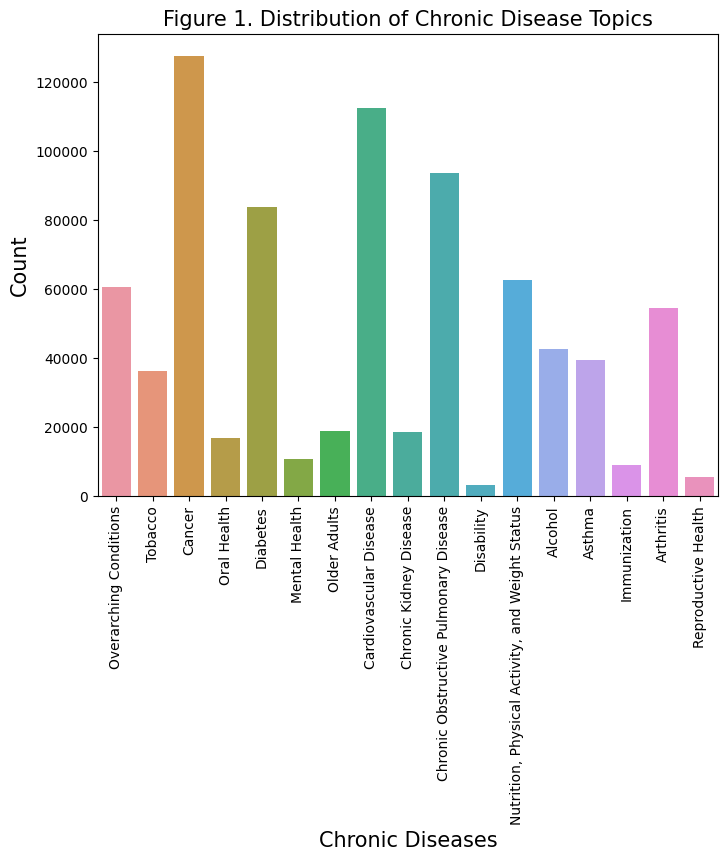

In [ ]:
# plot count of chronic disease
plt.figure(figsize=(8,6))
sns.countplot(x=clean_df['Topic'])
plt.xticks(rotation=90)
plt.xlabel('Chronic Diseases', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Figure 1. Distribution of Chronic Disease Topics', fontsize=15)
plt.show()

### Demographic Distribution

In [ ]:
clean_df['Stratification1'].unique()

array(['Overall', 'Female', 'Hispanic', 'Male', 'Black, non-Hispanic',
       'White, non-Hispanic', 'American Indian or Alaska Native',
       'Asian or Pacific Islander', 'Asian, non-Hispanic',
       'Multiracial, non-Hispanic', 'Other, non-Hispanic'], dtype=object)

In [ ]:
# Gender + Disease prevalence
male = clean_df[clean_df['Stratification1'] == 'Male']
female = clean_df[clean_df['Stratification1'] == 'Female']
m_group = male.groupby('Topic').size().reset_index(name='Count')
f_group= female.groupby('Topic').size().reset_index(name='Count')
gender_data = pd.merge(m_group, f_group, on='Topic', suffixes=('_Male', '_Female'))

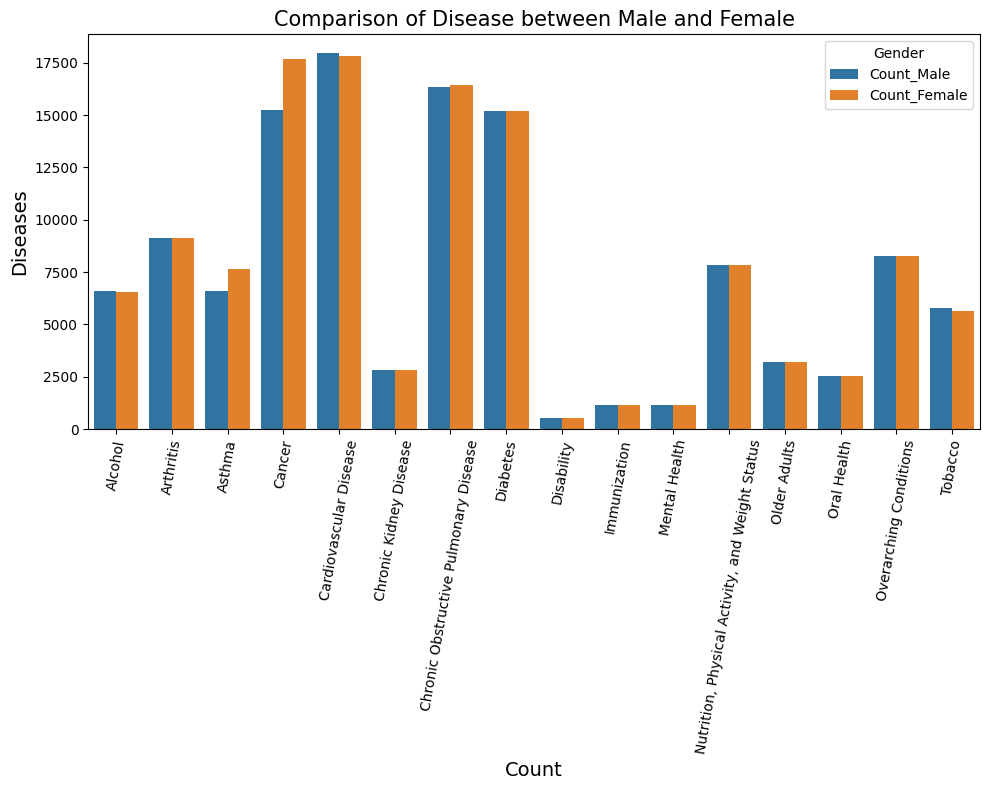

In [ ]:
plt.figure(figsize=(10,8))
sns.set_color_codes("pastel")
sns.barplot(data=gender_data.melt(id_vars='Topic'),
            x='Topic', y='value', hue='variable')
plt.title("Comparison of Disease between Male and Female", fontsize=15)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Diseases", fontsize=14)
plt.xticks(rotation=80)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

### Chronic Disease Distribution over the Year by States


In [ ]:
# data distribution by year groupped by states
filtered_df = clean_df[(clean_df['YearStart'] >= 2010) & (clean_df['YearStart'] <= 2021)]
grouped_data = filtered_df.groupby(['YearStart', 'LocationAbbr']).size().reset_index(name='count')
# grouped_data['YearStart'] = grouped_data['YearStart'].astype(int)
pivot_df = grouped_data.pivot(index='LocationAbbr', columns='YearStart', values='count')

fig = px.imshow(pivot_df,
                labels=dict(x='Year', y='State', color="Chronic Disease Value"),
                x=pivot_df.columns,
                y=pivot_df.index,
                aspect='auto',
                color_continuous_scale='Viridis',
                text_auto=True
                )
fig.update_layout(title='Figure 2. Chronic Disease Data Distribution by State and Year', xaxis_nticks=36)
fig.update_xaxes(tickmode='array', tickvals=list(range(2010, 2022)))

fig.show()

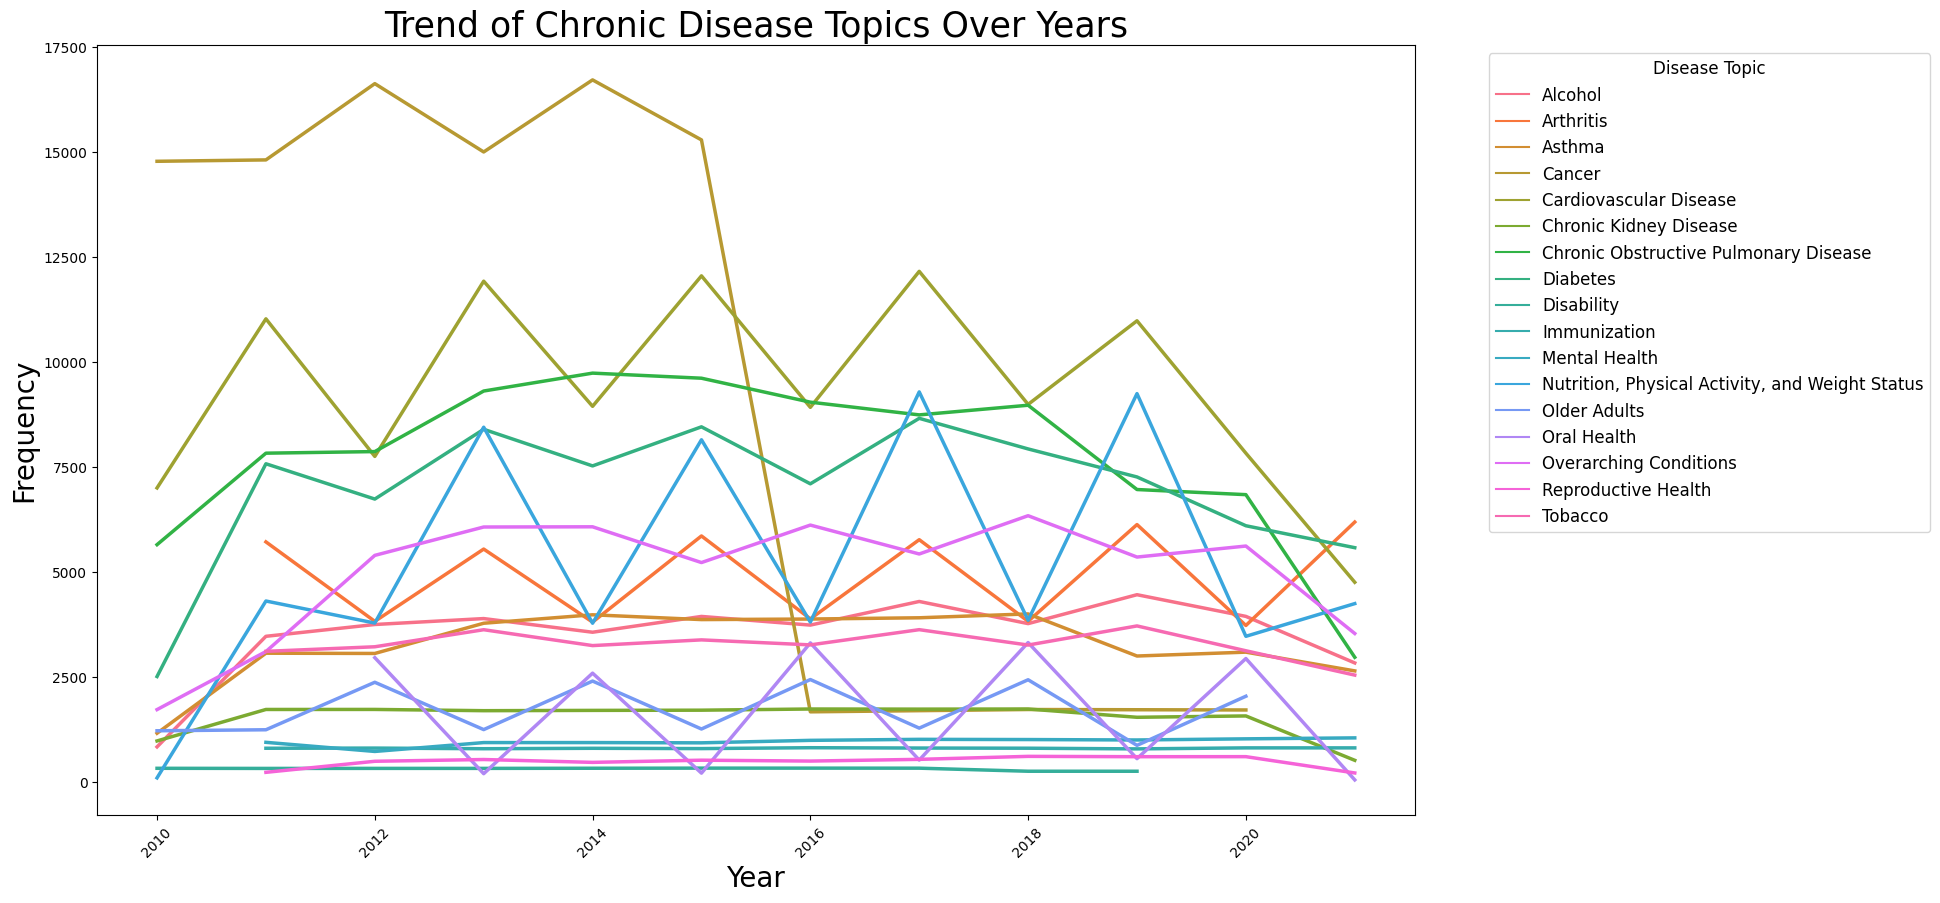

In [ ]:
# Plotting disease trend through years
year_filter_df = clean_df.copy()
year_filter_df = year_filter_df[year_filter_df['YearStart']>=2010]
topic_trends = year_filter_df.groupby(['YearStart', 'Topic']).size().unstack()

plt.figure(figsize=(17, 10))
palette = sns.cubehelix_palette(light=.8, n_colors=6)
sns.lineplot(data=topic_trends, dashes=False, linewidth=2.5)
plt.title('Trend of Chronic Disease Topics Over Years', fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(rotation=45)
plt.legend(title='Disease Topic', fontsize='large', title_fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Cluster Analysis using kmeans


In [ ]:
clean_df.head()

YearStart  YearEnd LocationAbbr                   Topic  \
0       2001     2001           NJ  Overarching Conditions   
1       2001     2001           OH  Overarching Conditions   
2       2001     2001           NJ  Overarching Conditions   
3       2001     2001           MA  Overarching Conditions   
4       2001     2001           KS  Overarching Conditions   

                          Question DataValueUnit DataValueType  DataValue  \
0         Life expectancy at birth         Years        Number       77.6   
1         Life expectancy at birth         Years        Number       76.5   
2  Life expectancy at age 65 years         Years        Number       18.1   
3  Life expectancy at age 65 years         Years        Number       18.7   
4         Life expectancy at birth         Years        Number       77.8   

   DataValueAlt StratificationCategory1 Stratification1  LocationID TopicID  \
0          77.6                 Overall         Overall          34     OVC   
1          76.5                 Overall         Overall          39     OVC   
2          18.1                 Overall         Overall          34     OVC   
3          18.7                 Overall         Overall          25     OVC   
4          77.8                 Overall         Overall          20     OVC   

  QuestionID DataValueTypeID StratificationCategoryID1 StratificationID1  \
0     OVC4_1            NMBR                   OVERALL               OVR   
1     OVC4_1            NMBR                   OVERALL               OVR   
2     OVC4_2            NMBR                   OVERALL               OVR   
3     OVC4_2            NMBR                   OVERALL               OVR   
4     OVC4_1            NMBR                   OVERALL               OVR   

   Longitude  Latitude  DeadStatus  
0 -74.273691  40.13057           1  
1 -82.404260  40.06021           1  
2 -74.273691  40.13057           1  
3 -72.082691  42.27687           1  
4 -98.200781  38.34774           1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



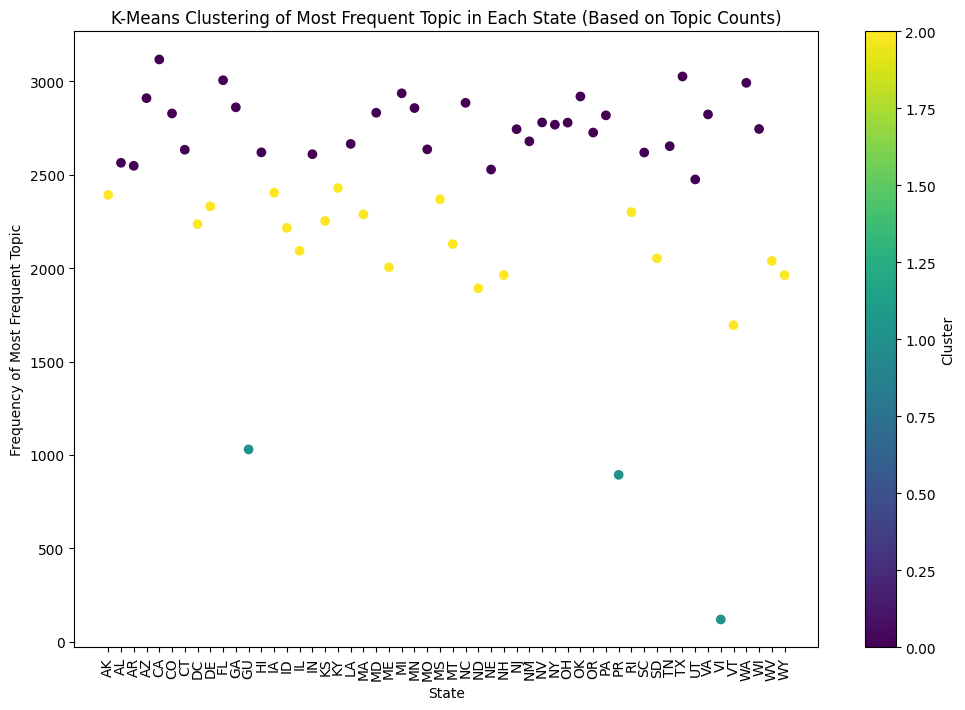

In [ ]:
cluster = clean_df[['YearStart', 'Topic', 'LocationAbbr']].copy()

# Encode the 'Topic' and 'LocationAbbr' columns
encoder = LabelEncoder()
cluster['Enc_Topic'] = encoder.fit_transform(cluster['Topic'])
encoder = LabelEncoder()
cluster['States'] = encoder.fit_transform(cluster['LocationAbbr'])

# store the count of each topic in each state
counts = cluster.groupby(['States', 'Enc_Topic'])['YearStart'].count().reset_index()
counts.rename(columns={'YearStart': 'Count'}, inplace=True)

# Find the most frequent topic in each state
mode = counts.groupby(['States'])['Count'].idxmax()
mode = counts.loc[mode, ['States', 'Count']]

# Map encoded state values to state abbreviations
state_abbr = dict(zip(cluster['States'], cluster['LocationAbbr']))

# Map the encoded states back to state
mode['State_Abbr'] = mode['States'].map(state_abbr)

kmeans = KMeans(n_clusters=3, random_state=0)
mode['Cluster'] = kmeans.fit_predict(mode[['Count']])

plt.figure(figsize=(12, 8))
plt.scatter(mode['State_Abbr'], mode['Count'], c=mode['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('K-Means Clustering of Most Frequent Topic in Each State (Based on Topic Counts)')
plt.xlabel('State')
plt.ylabel('Frequency of Most Frequent Topic')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


In [ ]:
silhouette_avg = silhouette_score(mode[['Count', 'Cluster']], mode['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6353530797092622


# Logistic Regression to Predict Death Rate

In [ ]:
unique_topics = clean_df['Topic'].unique()
data = {'Topic': unique_topics}

df = pd.DataFrame(data)

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(clean_df['Topic'])

# Concatenate the one-hot encoded columns with the original DataFrame
clean_df = pd.concat([clean_df, one_hot_encoded], axis=1)

In [ ]:
# create a column to keep track of duration of disease. Shows how fast people recover from the diseases
clean_df['diseaseDuration'] = clean_df['YearEnd'] - clean_df['YearStart']
clean_df['diseaseDuration'] = clean_df['diseaseDuration'].astype(str) + ' years'
clean_df['diseaseDuration'].value_counts().to_frame()

diseaseDuration
0 years           674874
4 years           118629
1 years             1224
2 years               92

In [ ]:
clean_df

YearStart  YearEnd LocationAbbr                   Topic  \
0            2001     2001           NJ  Overarching Conditions   
1            2001     2001           OH  Overarching Conditions   
2            2001     2001           NJ  Overarching Conditions   
3            2001     2001           MA  Overarching Conditions   
4            2001     2001           KS  Overarching Conditions   
...           ...      ...          ...                     ...   
794814       2021     2021           CO            Immunization   
794815       2021     2021           CO  Cardiovascular Disease   
794816       2021     2021           VA                 Alcohol   
794817       2021     2021           GU                Diabetes   
794818       2021     2021           MO  Overarching Conditions   

                                                 Question DataValueUnit  \
0                                Life expectancy at birth         Years   
1                                Life expectancy at birth         Years   
2                         Life expectancy at age 65 years         Years   
3                         Life expectancy at age 65 years         Years   
4                                Life expectancy at birth         Years   
...                                                   ...           ...   
794814  Influenza vaccination among noninstitutionaliz...             %   
794815  Awareness of high blood pressure among women a...             %   
794816  Binge drinking intensity among adults aged >= ...        Number   
794817  Glycosylated hemoglobin measurement among adul...             %   
794818  Current lack of health insurance among adults ...             %   

                  DataValueType  DataValue  DataValueAlt  \
0                        Number       77.6          77.6   
1                        Number       76.5          76.5   
2                        Number       18.1          18.1   
3                        Number       18.7          18.7   
4                        Number       77.8          77.8   
...                         ...        ...           ...   
794814         Crude Prevalence       49.0          49.0   
794815         Crude Prevalence       10.5          10.5   
794816        Age-adjusted Mean        8.2           8.2   
794817         Crude Prevalence       74.0          74.0   
794818  Age-adjusted Prevalence       12.4          12.4   

       StratificationCategory1  ... Disability  Immunization Mental Health  \
0                      Overall  ...          0             0             0   
1                      Overall  ...          0             0             0   
2                      Overall  ...          0             0             0   
3                      Overall  ...          0             0             0   
4                      Overall  ...          0             0             0   
...                        ...  ...        ...           ...           ...   
794814                 Overall  ...          0             1             0   
794815                 Overall  ...          0             0             0   
794816                  Gender  ...          0             0             0   
794817                 Overall  ...          0             0             0   
794818                 Overall  ...          0             0             0   

       Nutrition, Physical Activity, and Weight Status Older Adults  \
0                                                    0            0   
1                                                    0            0   
2                                                    0            0   
3                                                    0            0   
4                                                    0            0   
...                                                ...          ...   
794814                                               0            0   
794815                                               0            0   
79481

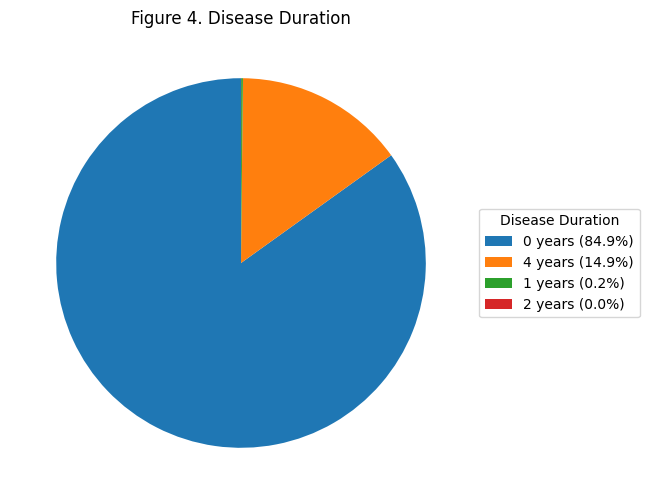

In [ ]:
clean_df['diseaseDuration'] = clean_df['diseaseDuration'].str.rstrip(' years')
clean_df['diseaseDuration'] = pd.to_numeric(clean_df['diseaseDuration'], errors='coerce')
plt.figure(figsize=(10, 6))
wedges, texts = plt.pie(clean_df["diseaseDuration"].value_counts(), startangle=90)

# Create a custom legend with percentages
legend_labels = [f"{duration} years ({percentage:.1f}%)"
                  for duration, percentage in zip(clean_df["diseaseDuration"].value_counts().index,
                                                   clean_df["diseaseDuration"].value_counts(normalize=True) * 100)]

plt.legend(legend_labels, title="Disease Duration", bbox_to_anchor=(1, 0.5), loc="center left")
plt.title('Figure 4. Disease Duration')
plt.show()

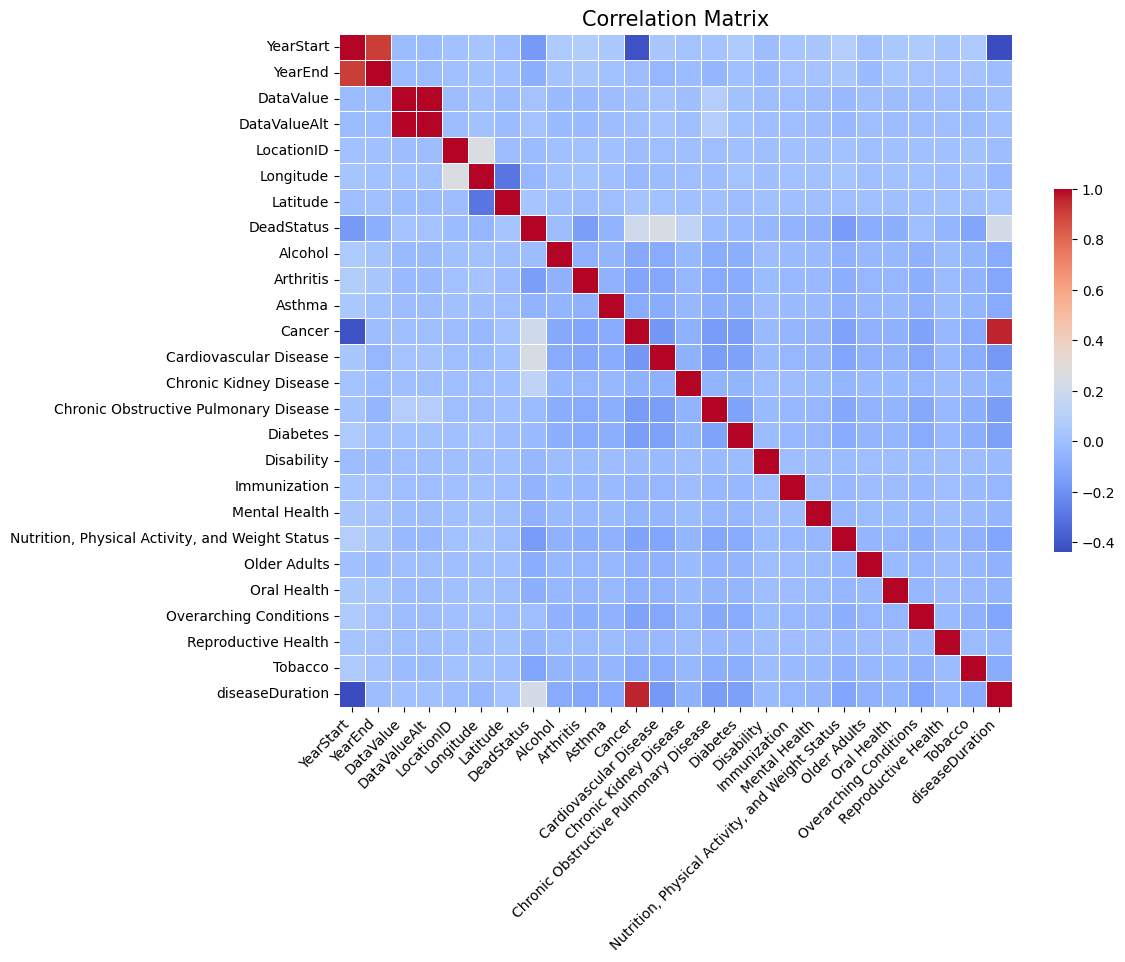

Index(['YearStart', 'DeadStatus', 'Arthritis', 'Cancer',
       'Cardiovascular Disease', 'Chronic Kidney Disease',
       'Nutrition, Physical Activity, and Weight Status', 'Tobacco',
       'diseaseDuration'],
      dtype='object')


In [ ]:
# Selecting only numeric columns for the correlation matrix
numeric_columns = clean_df.select_dtypes(include=['float64', 'int64', 'uint8'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

correlation_threshold = 0.1
selected_features = correlation_matrix['DeadStatus'][abs(correlation_matrix['DeadStatus']) > correlation_threshold].index
print(selected_features)


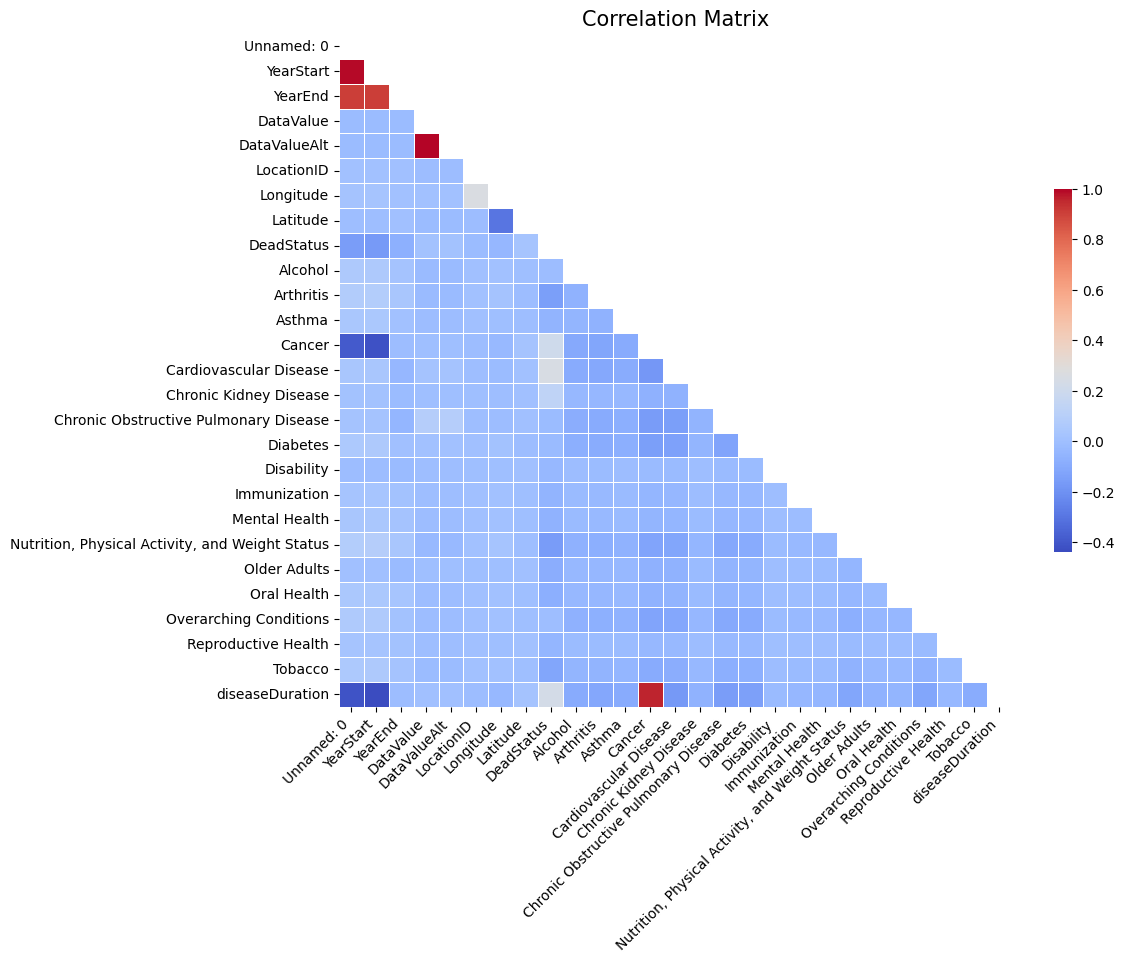

Index(['Unnamed: 0', 'YearStart', 'DeadStatus', 'Arthritis', 'Cancer',
       'Cardiovascular Disease', 'Chronic Kidney Disease',
       'Nutrition, Physical Activity, and Weight Status', 'Tobacco',
       'diseaseDuration'],
      dtype='object')


In [ ]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Selecting only numeric columns for the correlation matrix
numeric_columns = clean_df.select_dtypes(include=['float64', 'int64', 'uint8'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

correlation_threshold = 0.1
selected_features = correlation_matrix['DeadStatus'][abs(correlation_matrix['DeadStatus']) > correlation_threshold].index
print(selected_features)


In [ ]:
selected_columns = ['YearStart', 'Arthritis', 'Cancer', 'Cardiovascular Disease',
       'Chronic Kidney Disease',
       'Nutrition, Physical Activity, and Weight Status', 'Tobacco',
       'diseaseDuration']

# Drop rows with missing values in the selected columns
df_selected = clean_df[selected_columns + ['DeadStatus']].dropna()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[selected_columns], df_selected['DeadStatus'], test_size=0.2, random_state=42)

# Create a logistic regression model
logistic_model = LogisticRegression()

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the accuracy, classification report, and confusion matrix
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

y_probs = logistic_model.predict_proba(X_test)[:, 1]
fpr_logi, tpr_logi, thresholds = roc_curve(y_test, y_probs)
roc_auc_logi = auc(fpr_logi, tpr_logi)

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86    122261
           1       0.51      0.36      0.42     36703

    accuracy                           0.77    158964
   macro avg       0.67      0.63      0.64    158964
weighted avg       0.75      0.77      0.76    158964



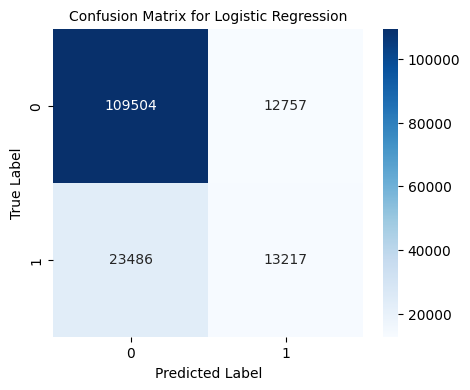

In [ ]:
# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression', fontsize=10)
plt.show()

# Naive Bayes to Predict Death Rate

In [ ]:
selected_columns = ['YearStart', 'Arthritis', 'Cancer', 'Cardiovascular Disease',
       'Chronic Kidney Disease',
       'Nutrition, Physical Activity, and Weight Status', 'Tobacco',
       'diseaseDuration']

# Drop rows with missing values in the selected columns
df_selected = clean_df[selected_columns + ['DeadStatus']].dropna()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[selected_columns], df_selected['DeadStatus'], test_size=0.2, random_state=42)

# Create a Naive Bayes model
naive_bayes_model = GaussianNB()

# Fit the model to the training data
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the scaled test set
y_pred = naive_bayes_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print the accuracy, classification report, and confusion matrix
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

y_probs = naive_bayes_model.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds = roc_curve(y_test, y_probs)
roc_auc_nb = auc(fpr_nb, tpr_nb)

Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40    122261
           1       0.29      1.00      0.44     36703

    accuracy                           0.42    158964
   macro avg       0.64      0.63      0.42    158964
weighted avg       0.84      0.42      0.41    158964



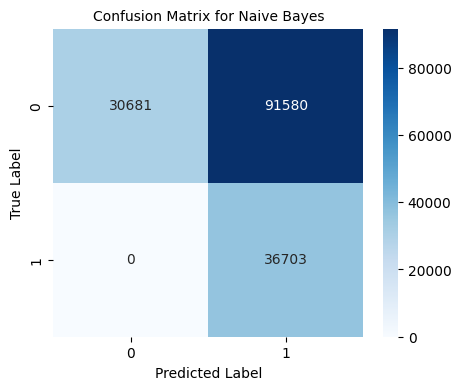

In [ ]:
# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes', fontsize=10)
plt.show()

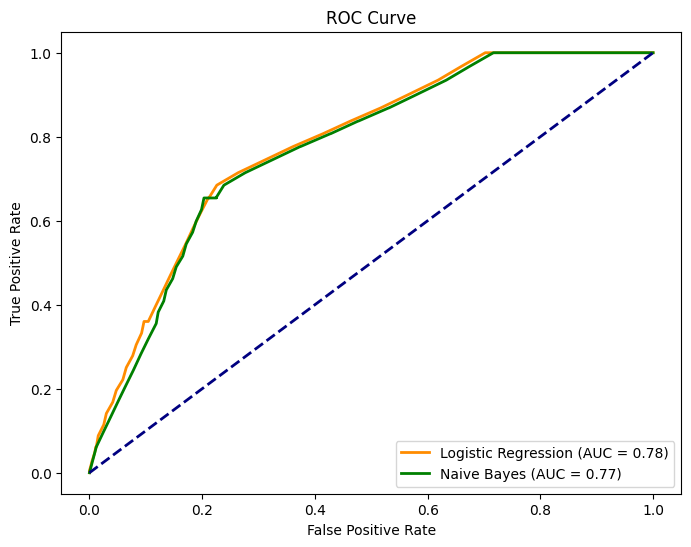

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_logi, tpr_logi, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logi:.2f})')
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Risk Level Classifier

In [ ]:
clean_df.columns

Index(['Unnamed: 0', 'YearStart', 'YearEnd', 'LocationAbbr', 'Topic',
       'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'StratificationCategory1', 'Stratification1',
       'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1', 'Longitude',
       'Latitude', 'DeadStatus', 'Alcohol', 'Arthritis', 'Asthma', 'Cancer',
       'Cardiovascular Disease', 'Chronic Kidney Disease',
       'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Disability',
       'Immunization', 'Mental Health',
       'Nutrition, Physical Activity, and Weight Status', 'Older Adults',
       'Oral Health', 'Overarching Conditions', 'Reproductive Health',
       'Tobacco', 'diseaseDuration'],
      dtype='object')

In [ ]:
# clean_df.to_csv("Final_health_indicator.csv")

In [ ]:
clean_df['DataValue'].dtype

dtype('float64')

In [ ]:
print(clean_df['DataValue'].min())
print(clean_df['DataValue'].max())

0.0
701437.0


In [ ]:
# create `RiskLevel` based on `DataValue`
bins = [-1, 100000, 250000, 500000, 701437]
labels = ['Low', 'Moderate', 'High', 'Very High']
clean_df['RiskLevel'] = pd.cut(clean_df['DataValueAlt'],
                               bins=bins,
                               labels=labels)


In [ ]:
X = clean_df[['LocationAbbr', 'diseaseDuration', 'DataValue', 'DeadStatus', 'TopicID',
              'Alcohol', 'Arthritis', 'Asthma', 'Cancer', 'Cardiovascular Disease',
              'Chronic Kidney Disease', 'Chronic Obstructive Pulmonary Disease',
              'Diabetes', 'Disability', 'Immunization', 'Mental Health',
              'Nutrition, Physical Activity, and Weight Status', 'Older Adults',
              'Oral Health', 'Overarching Conditions', 'Reproductive Health','Tobacco']]

# one-hot encoder for string type value in `LocationAbbr`
X = pd.get_dummies(X)

y = clean_df['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# model define
rf_classification = RandomForestClassifier()
rf_classification.fit(X_train, y_train)

acc = rf_classification.score(X_test, y_test)
print(f"Accuracy score evaluated on test set:", acc)

Accuracy score evaluated on test set: 0.9999706432483665


In [ ]:
# make prediction on X_test
y_pred = rf_classification.predict(X_test)
eval_report = classification_report(y_test, y_pred)
print(eval_report)

              precision    recall  f1-score   support

        High       0.93      0.93      0.93        27
         Low       1.00      1.00      1.00    238236
    Moderate       0.98      0.99      0.99       180
   Very High       1.00      0.33      0.50         3

    accuracy                           1.00    238446
   macro avg       0.98      0.81      0.85    238446
weighted avg       1.00      1.00      1.00    238446



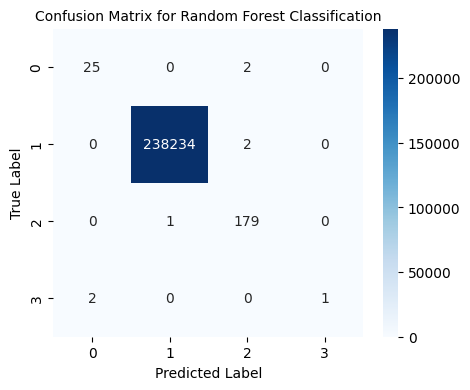

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classification', fontsize=10)
plt.show()

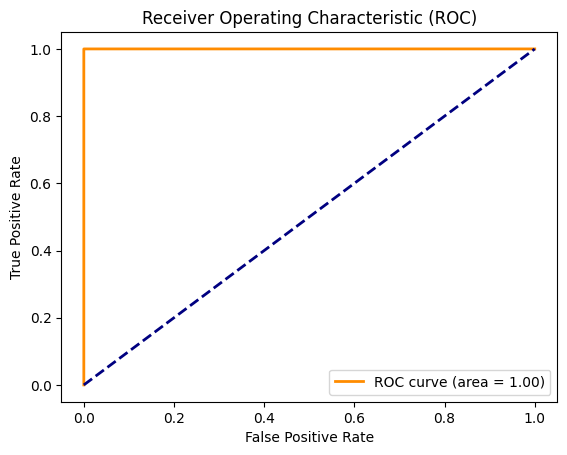

In [ ]:
# plot ROC curve
# Binarize the output
y_test_bin = label_binarize(y_test, classes=labels)
y_pred_bin = label_binarize(y_pred, classes=labels)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# plot the random forest classifier with plot_tree
estimator = rf_classification.estimators_[4]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(40,40), dpi=400)
plot_tree(estimator, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, ax=axes)
plt.show()

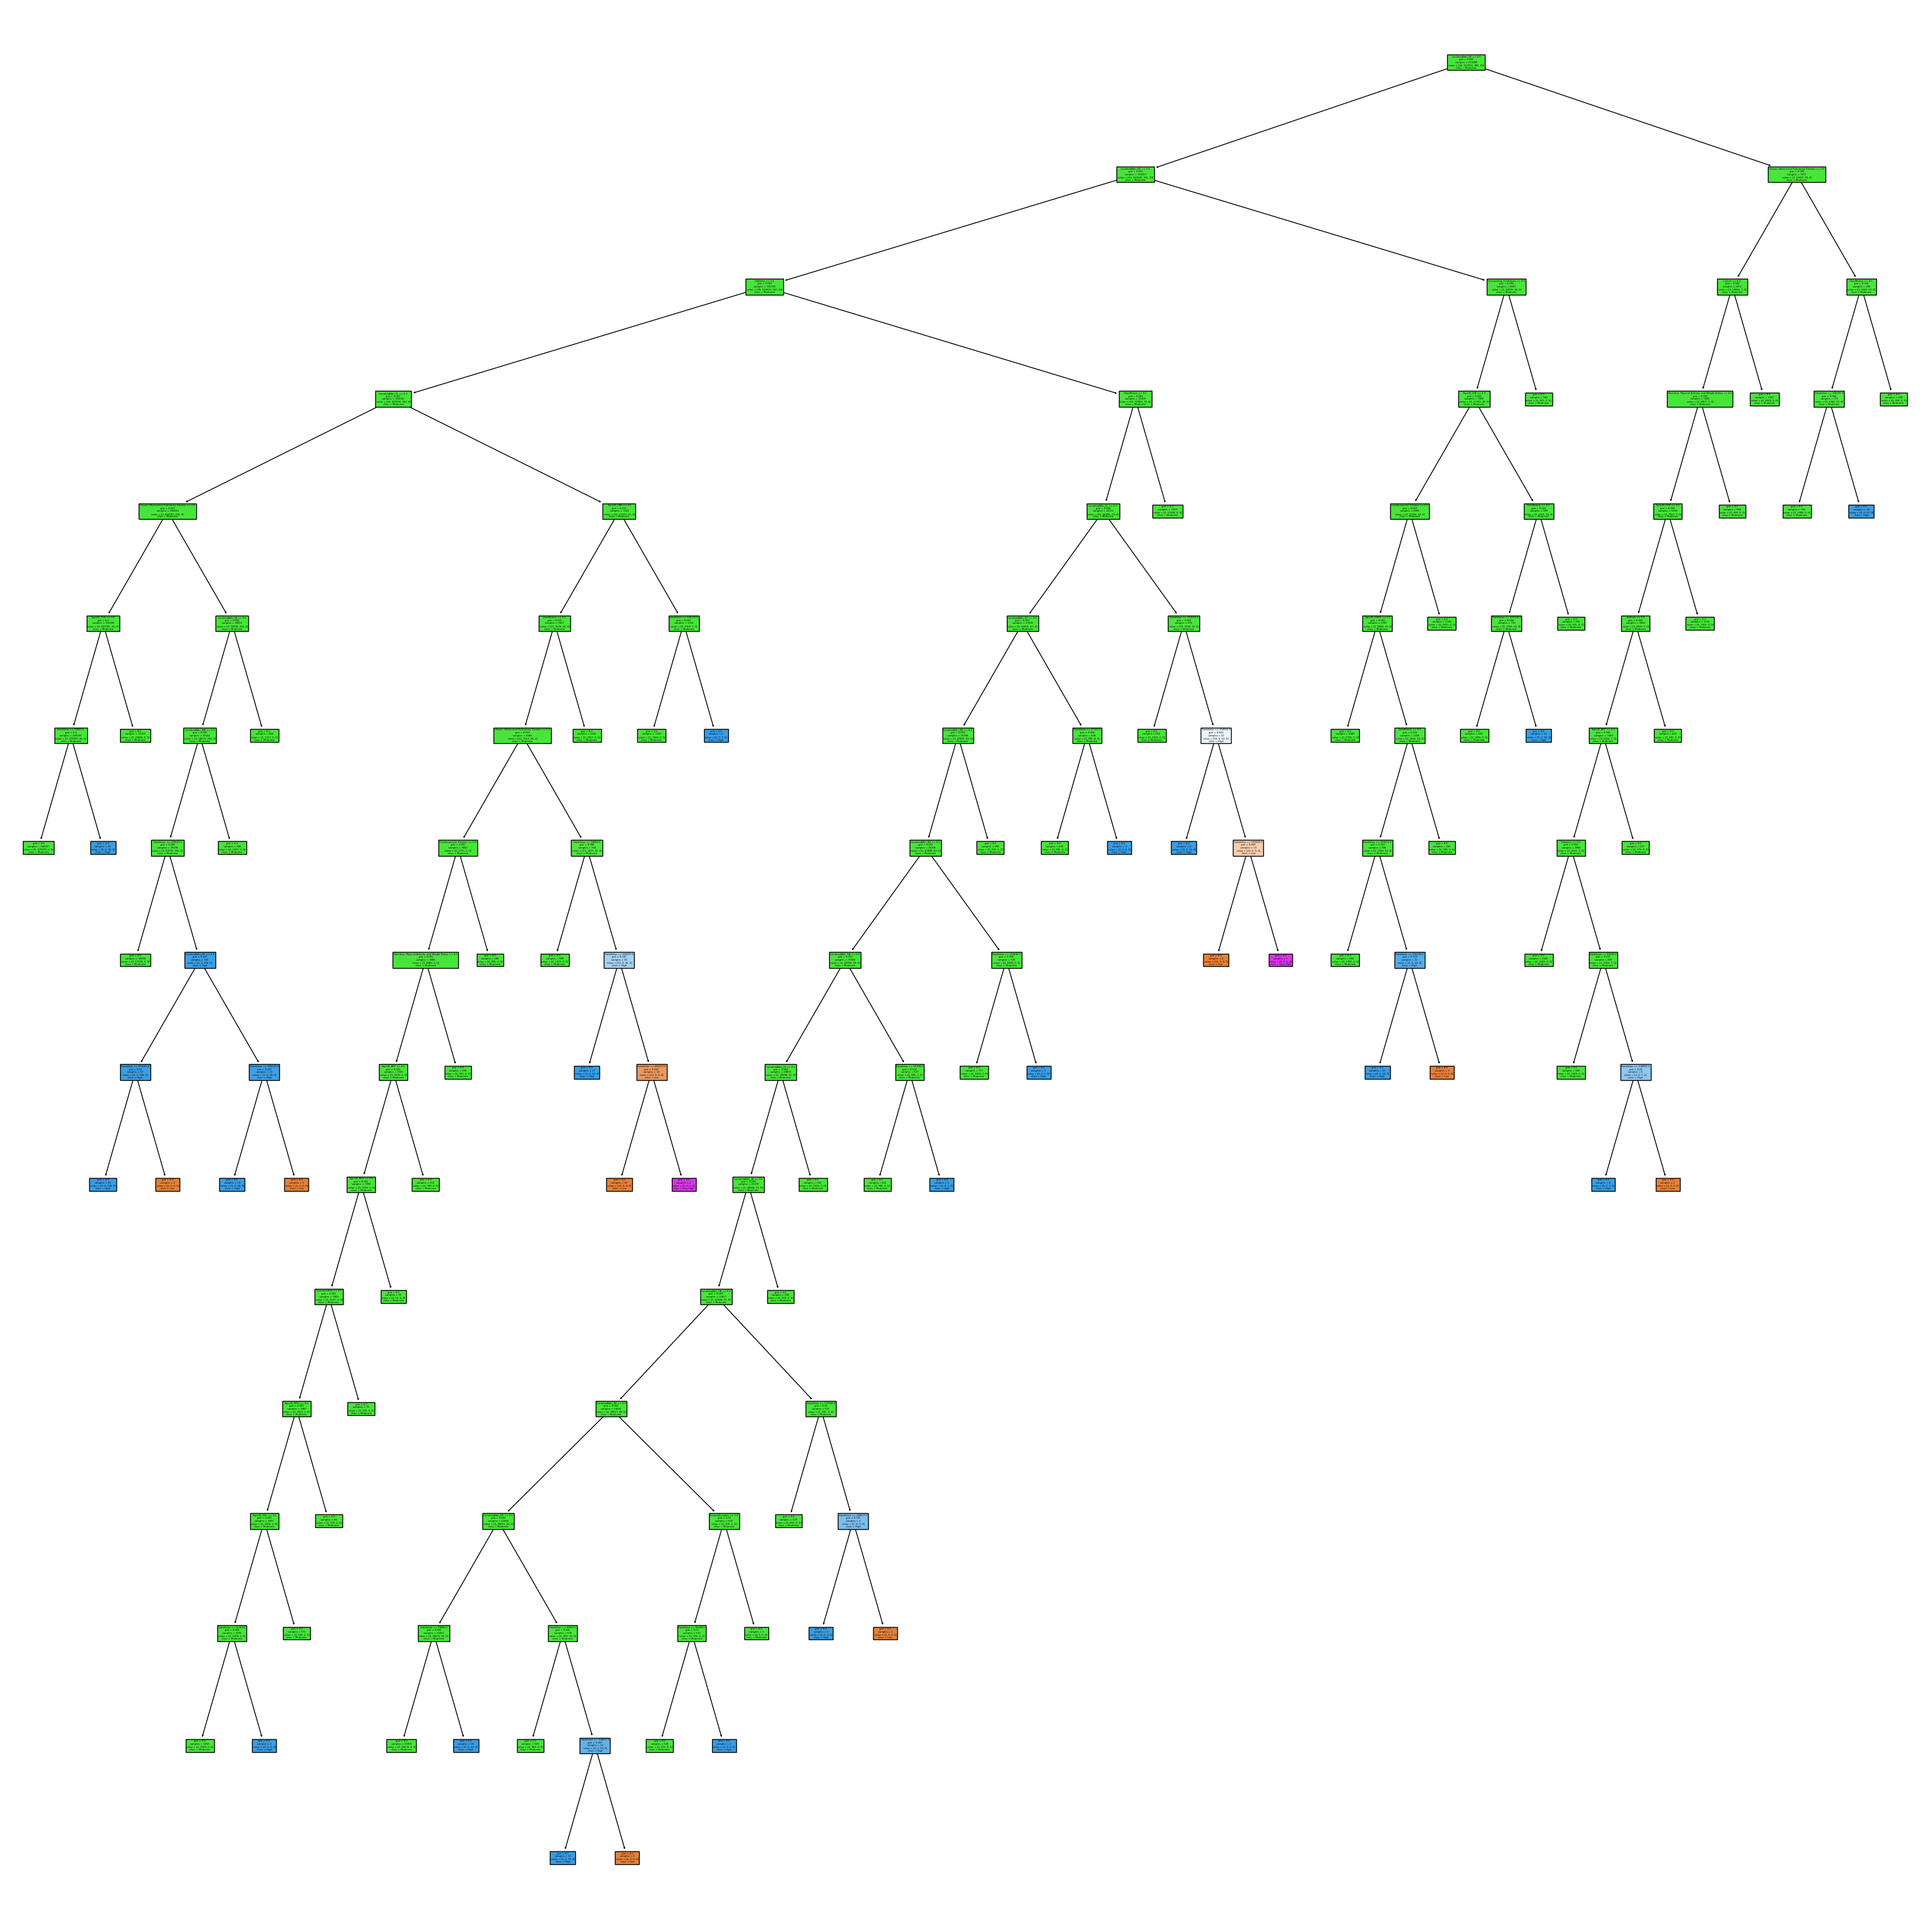

In [ ]:
# plot the first tree only
tree1 = rf_classification.estimators_[0]
plt.figure(figsize=(40,40))
plot_tree(tree1, filled=True, feature_names=X_train.columns, class_names=y_train.unique())
plt.savefig('decision_tree_1.png', format='png', dpi=300)
plt.show()